In [68]:
library(CausalImpact)
library(matrixStats)
library(dtw)
library(forecast)

In [2]:
data <- read.csv(file = 'CausalImpact_homework_data1.csv', header = TRUE, sep = ',')

In [3]:
head(data)

date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
2013-12-18,21110.60,5855898,10490066,6400020,17303909,8277376,202418.0,501304.0,281527.7,⋯,2.46,20.30,11.76,13.53,27.36,23.53,41.25,NA,23.73,9.24
2013-12-19,19985.20,5233946,8856544,5772768,13711773,7417712,195205.4,456269.5,222715.5,⋯,2.05,13.05,12.25,14.76,28.50,28.96,37.95,11.94,31.64,6.93
2013-12-20,19602.36,4923801,8346250,5429014,12574661,6999351,205468.9,496172.0,283458.8,⋯,1.23,23.20,10.78,9.84,45.03,27.15,34.65,7.96,28.25,3.85
2013-12-21,21955.16,6061035,10408902,6624329,17318726,8561364,210051.0,516636.4,272849.0,⋯,3.28,24.65,10.78,11.07,44.46,25.34,36.30,5.97,38.42,8.47
2013-12-22,22388.32,6139137,10323537,6646342,16883212,8662216,217223.1,530008.4,269956.1,⋯,1.23,31.90,12.74,11.07,53.01,23.53,49.50,3.98,39.55,5.39
2013-12-23,23793.20,6368549,10494566,6864796,17262817,8962794,209871.1,536184.1,308934.5,⋯,1.64,26.10,6.86,8.61,51.87,18.10,46.20,3.98,35.03,12.32


In [4]:
intervention <- read.csv(file = 'CausalImpact_homework_data2.csv', header = TRUE, sep = ',')

In [5]:
head(intervention)

num,start_date,end_date,estimation_size_of_marketing_activity,is_related_to_our_service
1,26,56,4.6,1
2,31,60,0.1,0
3,52,66,0.5,1
4,111,144,5.7,1
5,174,197,2.6,0
6,200,212,10.0,0


Видим в intervention много нерелевантных по времени кампаний. Чтобы их отсеять, найдем, какие номера соответствуют началу и концу анализируемого периода:

In [6]:
num_start <- which(as.Date(data$date) >= as.Date("2015-08-01"))[1]
num_end <- which(as.Date(data$date) >= as.Date("2015-12-01"))[1] - 1

In [7]:
intervention <- intervention[intervention$end_date >= num_start & intervention$start_date <= num_end, ]

В data данные после ноября 2015 нам тоже не нужны. До августа 2015 нужны, так как на них будем обучаться:

In [8]:
data <- data[1:num_end, ]

Посмотрим, что осталось в intervention:

In [9]:
intervention

,num,start_date,end_date,estimation_size_of_marketing_activity,is_related_to_our_service
22,22,560,599,4.9,0
25,25,623,637,1.5,1
26,26,623,668,0.1,1
27,27,630,668,0.0,0
28,28,633,644,0.7,0
29,29,651,667,0.4,0
30,30,690,720,0.2,1
31,31,694,707,0.0,1
32,32,697,730,0.1,0
33,33,708,725,1.5,1


Первая кампания не нужна, так как она не относится к нашему сервису и не влият на относящиеся кампании, потому что не пересекается с ними по времени. Уберем ее:

In [10]:
intervention <- intervention[2:nrow(intervention), ]

Итак, видно, что первая интересующая нас кампания начинается на 623-й день. С этого же периода можно будет считать, что target оказался подверженным воздействию и пытаться оценивать эффективности кампаний. Посмотрим, что это за дата:

In [11]:
data[623, ]

,date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
623,2015-09-01,402400.9,18744564,27471358,14500756,52415833,26232159,995043.3,1794159,314299.4,⋯,94.3,1023.7,745.78,143.91,1263.69,331.23,4499.55,224.87,1589.91,171.71


В качестве времени, когда target не был подвержен кампаниям, относящимся к нашему сервису, таким образом можно считать дни от 456 до 622 включительно (455 -- последний день кампаний, которые is_related_to_our_service, до 623 дня). Именно этот период мы будем рассматривать при выборе ряда-предиктора, когда нам нужно будет понять, что предиктор может прогнозировать таргет в условиях, когда кампании, относящиеся к сервису, не проводятся.

In [12]:
data[456, ]

,date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
456,2015-03-18,271340.4,13596933,19966044,10680066,43155813,19059119,865486.1,1433803,301570.4,⋯,21.32,574.2,378.28,51.66,387.6,133.94,651.75,67.66,857.67,84.7


Давайте тогда оставим данные от 18 марта до 30 ноября 2015:

In [13]:
data <- data[456:nrow(data), ]

In [14]:
head(data)

,date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
456,2015-03-18,271340.4,13596933,19966044,10680066,43155813,19059119,865486.1,1433803,301570.4,⋯,21.32,574.20,378.28,51.66,387.60,133.94,651.75,67.66,857.67,84.70
457,2015-03-19,267945.2,13250533,19590436,10453814,43211262,18583910,879163.2,1437657,281317.0,⋯,24.60,636.55,425.32,67.65,481.08,190.05,732.60,79.60,937.90,80.08
458,2015-03-20,261622.5,12288823,18556680,9747972,43266712,17266068,838302.0,1362299,264518.3,⋯,24.19,597.40,420.42,59.04,479.94,228.06,765.60,81.59,1066.72,77.77
459,2015-03-21,289697.0,15666805,22335362,12152473,43322161,21895386,928537.7,1531178,311173.2,⋯,36.08,713.40,425.81,77.49,489.06,231.68,742.50,71.64,1157.12,89.32
460,2015-03-22,264950.4,14549435,21824108,11482922,43377610,20328812,938637.1,1553960,309376.3,⋯,25.83,771.40,450.80,62.73,498.75,257.02,768.90,99.50,1203.45,95.48
461,2015-03-23,277191.8,14870556,21910612,11725615,43433059,20802817,950107.1,1577942,308639.5,⋯,24.60,653.95,461.58,78.72,493.05,179.19,730.95,67.66,1058.81,88.55


Посмотрим теперь, как выглядит target:

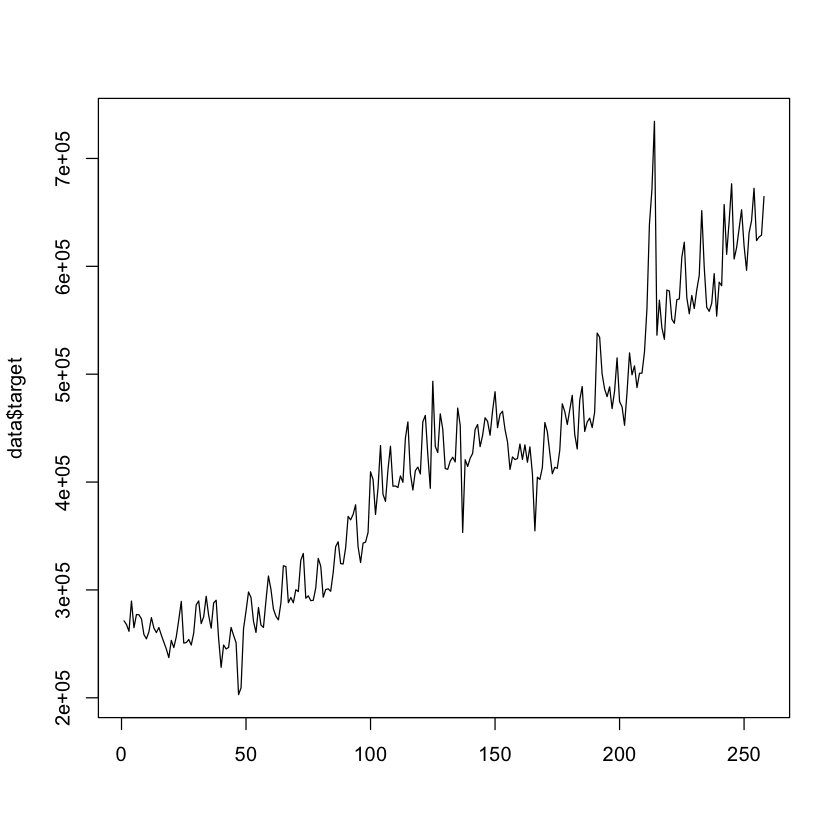

In [15]:
matplot(data$target, type = "l")

Теперь уже можно начать искать ряды-предикторы.

Чтобы было удобно сравнивать похожесть рядов, давайте их отмасштабируем. Для этого еще удалим все N/A. Благо, таких строк в нужных данных, меньше 2%:

In [16]:
sum(complete.cases(data)) / nrow(data)

[1] 0.9806202

In [17]:
data <- data[complete.cases(data), ]

Отнимаем минимумы по колонкам:

In [18]:
data_wo_date <- data[2:ncol(data)]
col_mins <- colMins(as.matrix(data_wo_date))
data[2:ncol(data)] <- data_wo_date - matrix(col_mins, nrow = nrow(data), ncol = ncol(data) - 1, byrow = TRUE)

Делим на максимумы:

In [19]:
data_wo_date <- data[2:ncol(data)]
col_maxs <- colMaxs(as.matrix(data_wo_date))
data[2:ncol(data)] <- data_wo_date / matrix(col_maxs, nrow = nrow(data), ncol = ncol(data) - 1, byrow = TRUE)

In [20]:
head(data)

,date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
456,2015-03-18,0.1287647,0.1881549,0.2415237,0.4325784,0.000000000,0.1874516,0.1539666,0.10869271,0.1978419,⋯,0.01168969,0.04060150,0.05399196,0.02068966,0.00000000,0.009195402,0.00284540,0.03225806,0.00000000,0.05992509
457,2015-03-19,0.1223768,0.1738043,0.2256490,0.4205622,0.003891050,0.1733050,0.1733243,0.11114903,0.1574607,⋯,0.02019129,0.10526316,0.10913268,0.11034483,0.06940330,0.080459770,0.01833702,0.05645161,0.03056393,0.03745318
458,2015-03-20,0.1104812,0.1339628,0.1819583,0.3830750,0.007782101,0.1340739,0.1154919,0.06311888,0.1239675,⋯,0.01912859,0.06466165,0.10338886,0.06206897,0.06855692,0.128735632,0.02466013,0.06048387,0.07963840,0.02621723
459,2015-03-21,0.1633013,0.2739051,0.3416608,0.5107779,0.011673151,0.2718850,0.2432059,0.17075550,0.2169879,⋯,0.04994687,0.18496241,0.10970706,0.16551724,0.07532797,0.133333333,0.02023396,0.04032258,0.11407663,0.08239700
460,2015-03-22,0.1167425,0.2276150,0.3200531,0.4752181,0.015564202,0.2252493,0.2575000,0.18527575,0.2134052,⋯,0.02337938,0.24511278,0.13900057,0.08275862,0.08252222,0.165517241,0.02529244,0.09677419,0.13172622,0.11235955
461,2015-03-23,0.1397737,0.2409183,0.3237091,0.4881075,0.019455253,0.2393601,0.2737339,0.20056086,0.2119362,⋯,0.02019129,0.12330827,0.15163699,0.17241379,0.07829031,0.066666667,0.01802087,0.03225806,0.07662505,0.07865169


Получили во всех колонках значения от 0 до 1.

Теперь такие ряды можно сравнить визуально и выбрать подходящий predictor. Сравнивать будем весь период с 18 марта до 31 августа, но потом еще проверим, что зависимость с сентября по конец ноября между предиктором и таргетом меняется не сильно.

In [21]:
data[164, ]

,date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
622,2015-08-31,0.3794073,0.4053603,0.5832764,0.6448052,0.6459144,0.4047193,0.3815882,0.3684181,0.2162165,⋯,0.2082891,0.4842105,0.5169443,0.4482759,0.6957258,0.3563218,0.7922858,0.4072581,0.329746,0.4044944


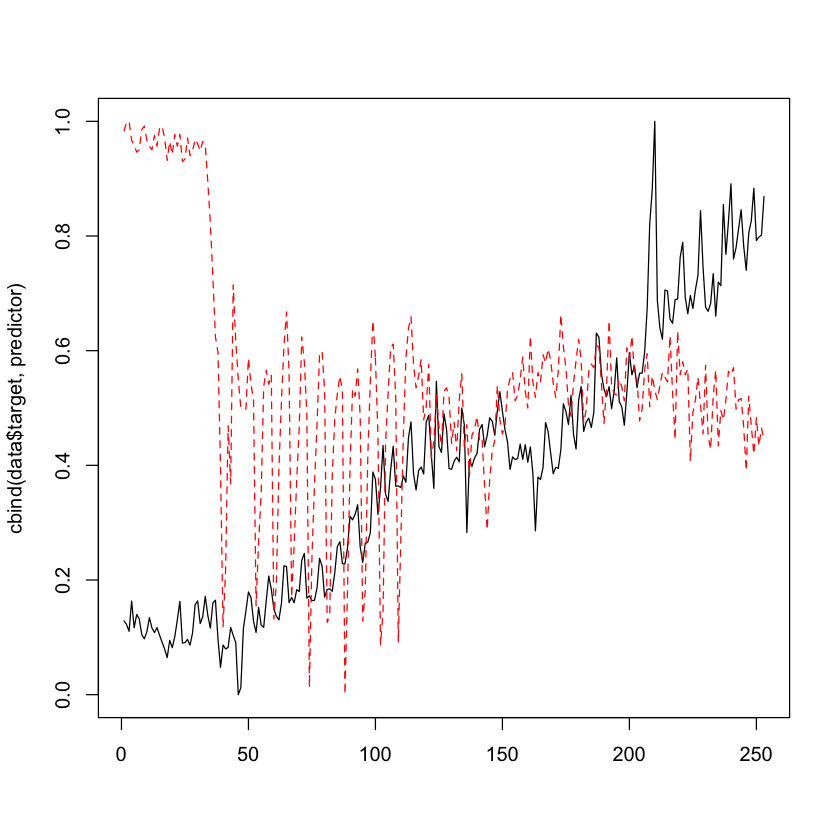

In [49]:
predictor <- -data$may_be_not_impacted_2 + 1
matplot(cbind(data$target, predictor), type = "l")

Сразу становится понятно, что визуально все предикторы похожи и выбрать лучший исключительно на глаз сложно. Тем более, что некоторые может быть придется смещать или инвертировать. Поэтому воспользуемся dynamic time wrappering, чтобы найти лучшую серию.

In [56]:
ind <- c(1:164)
get_dist <- function(predictor){
res1 <- dtw(data$target[ind], predictor[ind], distance.only = TRUE)$distance
res2 <- dtw(data$target[ind], -predictor[ind] + 1, distance.only = TRUE)$distance
return(c(res1, res2))
}

In [62]:
get_dist(data$may_be_not_impacted_2)
get_dist(data$may_be_not_impacted_3)
get_dist(data$may_be_not_impacted_4)
get_dist(data$may_be_not_impacted_5)
get_dist(data$may_be_not_impacted_6)
get_dist(data$may_be_not_impacted_7)
get_dist(data$may_be_not_impacted_8)
get_dist(data$may_be_not_impacted_9)
get_dist(data$may_be_not_impacted_10)
get_dist(data$may_be_not_impacted_11)
get_dist(data$may_be_not_impacted_12)

[1] 18.05192 47.97117

[1] 17.51605 68.75496

[1] 18.52951 66.62314

[1] 15.97694 69.28736

[1] 18.54152 58.33473

[1] 19.67012 66.84219

[1] 14.88572 56.52607

[1] 39.47818 55.49863

[1] 21.37567 51.88273

[1] 13.29661 88.94772

[1] 18.92519 60.62187

5, 8, 11

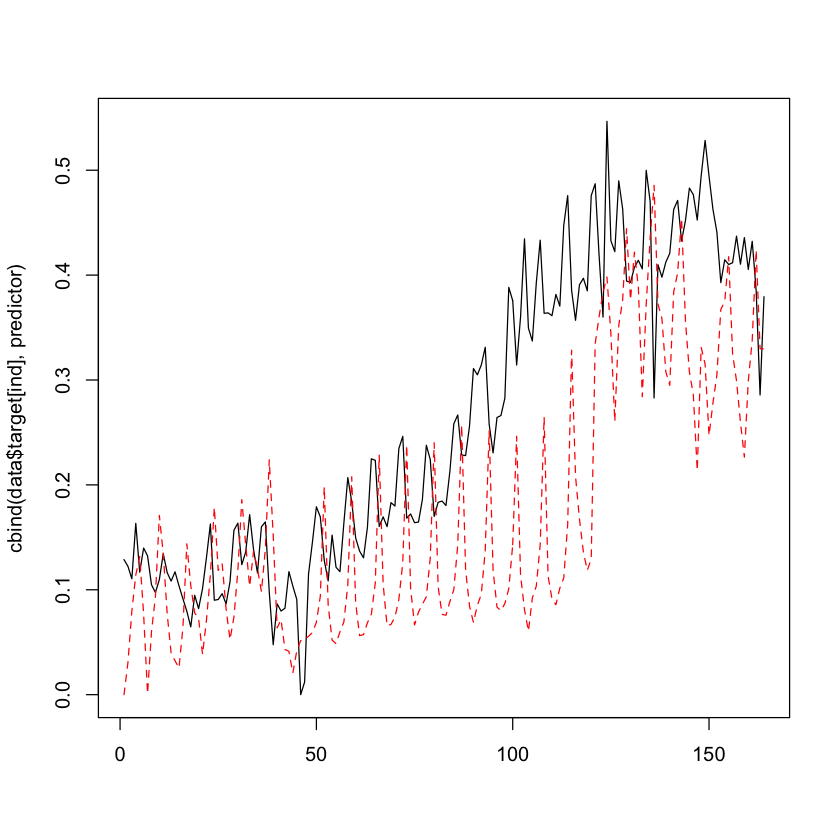

In [88]:
# predictor <- data$may_be_not_impacted_11[ind]
matplot(cbind(data$target[ind], predictor), type = "l")

In [87]:
predictor[45:120] <- sd1 * (predictor[45:120] - min(predictor[45:120])) / sd2 + min(predictor[45:120])

In [85]:
sd2 <- sd(predictor[45:120])

In [86]:
sd1 <- sd(predictor[120:length(predictor)])

Warning message in cbind(target, predictor):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message:
“Removed 253 rows containing missing values (geom_path).”Warning message:
“Removed 89 rows containing missing values (geom_path).”Warning message:
“Removed 506 rows containing missing values (geom_path).”

Posterior inference {CausalImpact}

                         Average        Cumulative    
Actual                   0.39           31.72         
Prediction (s.d.)        0.16 (0.014)   13.41 (1.150) 
95% CI                   [0.14, 0.19]   [11.15, 15.64]
                                                      
Absolute effect (s.d.)   0.22 (0.014)   18.30 (1.150) 
95% CI                   [0.2, 0.25]    [16.1, 20.57] 
                                                      
Relative effect (s.d.)   136% (8.6%)    136% (8.6%)   
95% CI                   [120%, 153%]   [120%, 153%]  

Posterior tail-area probability p:   0.00101
Posterior prob. of a causal effect:  99.8994%

For more details, type: summary(impact, "report")



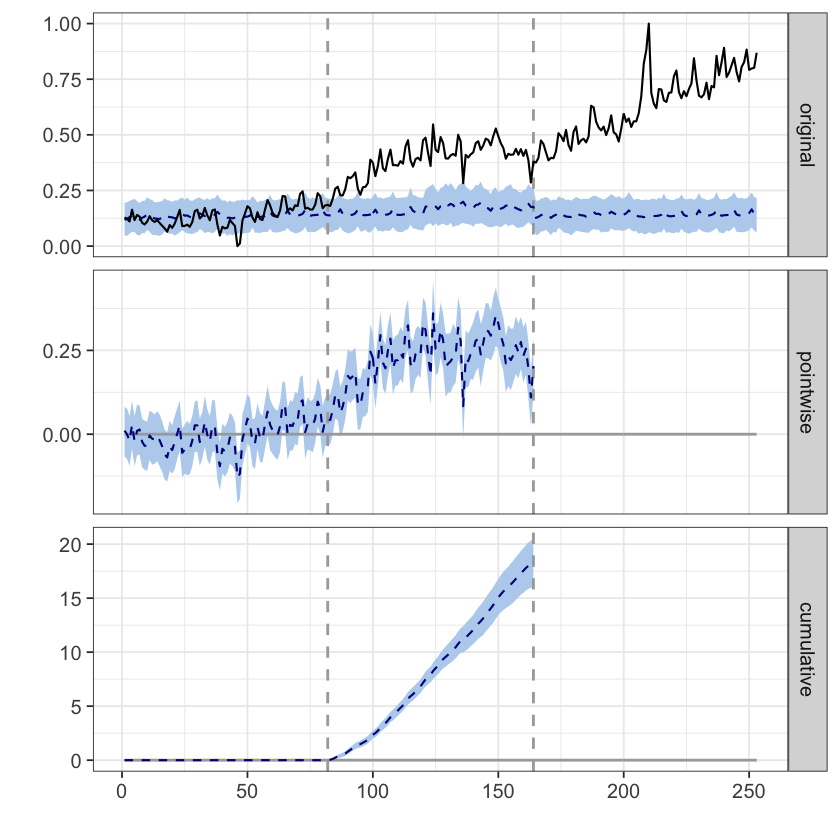

In [89]:
pre.period <- c(1, 82)
post.period <- c(83, 164)

# pre.period <- c(1, 80)
# post.period <- c(81, 141)

set.seed(0)
target <- data$target
impact <- CausalImpact(cbind(target, predictor), pre.period, post.period)
plot(impact)
summary(impact)